In [1]:
import numpy as np
import pandas as pd
import random
import shap
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve
import seaborn as sns

#==================================Part 1==============================================================
# Load real dataset (instead of generating synthetic data)

seed_df = pd.read_csv('dataset.csv')

# Drop isFlaggedFraud if it exists (we'll compute our own)
if 'isFlaggedFraud' in seed_df.columns:
    seed_df = seed_df.drop(columns=['isFlaggedFraud'])

# Sample transactions (use min of 100,000 or available rows)
sample_size = min(100000, len(seed_df))
syn = seed_df.sample(n=sample_size, random_state=42)

print("Dataset shape:", syn.shape)
print("Fraud rate:", syn['isFraud'].mean())

Dataset shape: (100000, 10)
Fraud rate: 0.00141


In [2]:
#==================================Part 2==============================================================
from geopy.distance import geodesic

# Assign random lat/lon per account for geolocation rule
loc_o = {acc: (random.uniform(-90,90), random.uniform(-180,180))
         for acc in syn['nameOrig'].unique()}
loc_d = {acc: (random.uniform(-90,90), random.uniform(-180,180))
         for acc in syn['nameDest'].unique()}
syn['locOrig'] = syn['nameOrig'].map(loc_o)
syn['locDest'] = syn['nameDest'].map(loc_d)


#==================================Part 3==============================================================
def apply_rules(df):
    """Apply 7 fraud detection rules to the dataframe."""
    # Initialize flags
    for i in range(1,8):
        df[f'rule{i}']=0
    # History per account
    history = {}
    df.sort_values(['nameOrig','step'], inplace=True)
    for idx,row in df.iterrows():
        acct = row['nameOrig']
        amt, tp, dest, ts = row['amount'], row['type'], row['nameDest'], row['step']
        loc1, loc2 = row['locOrig'], row['locDest']
        if acct not in history:
            history[acct] = {'times':[], 'dests':set(), 'type_amts':{}}
        h = history[acct]
        # 1) Amount Threshold
        if amt>50000: df.at[idx,'rule1']=1
        # 2) Velocity: >5 txns last hour
        recent = [t for t in h['times'] if ts-t<=1]
        if len(recent)>=5: df.at[idx,'rule2']=1
        # 3) Time-of-Day 0-5h
        if (ts%24)<5: df.at[idx,'rule3']=1
        # 4) Type-Amount mismatch
        if (tp=='CASH_OUT' and amt<10) or (tp=='TRANSFER' and amt>80000):
            df.at[idx,'rule4']=1
        # 5) New beneficiary
        if dest not in h['dests']: df.at[idx,'rule5']=1
        # 6) Geolocation >500km
        if geodesic(loc1, loc2).km>500: df.at[idx,'rule6']=1
        # 7) Behavior inconsistency
        lst = h['type_amts'].get(tp,[])
        if len(lst)>=10:
            mu, sd = np.mean(lst), np.std(lst)
            if abs(amt-mu)>3*sd: df.at[idx,'rule7']=1
        # Update history
        h['times'].append(ts)
        h['dests'].add(dest)
        h['type_amts'].setdefault(tp,[]).append(amt)
    # Final flag
    df['isFlaggedFraud'] = df[[f'rule{i}' for i in range(1,8)]].max(axis=1)
    return df

syn = apply_rules(syn)
print(syn[['rule1','rule2','rule3','rule4','rule5','rule6','rule7','isFlaggedFraud']].head())

         rule1  rule2  rule3  rule4  rule5  rule6  rule7  isFlaggedFraud
466587       0      0      0      0      1      1      0               1
1842804      1      0      0      0      1      1      0               1
1379331      0      0      0      0      1      1      0               1
271891       0      0      0      0      1      1      0               1
860578       0      0      0      0      1      1      0               1


In [3]:
#==================================Part 4==============================================================
# Data Preprocessing

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import joblib

# 4.1 Prepare model dataframe
model_df = syn.drop(columns=['locOrig','locDest']+[f'rule{i}' for i in range(1,8)])

# 4.2 Encode categorical columns and SAVE the encoders (BUG FIX)
label_encoders = {}
for col in ['type','nameOrig','nameDest']:
    le = LabelEncoder()
    model_df[col] = le.fit_transform(model_df[col])
    label_encoders[col] = le

# Save label encoders
joblib.dump(label_encoders, 'label_encoders.pkl')
print("Label encoders saved")

# 4.3 Split features/labels - KEEP isFlaggedFraud as feature (BUG FIX)
X = model_df.drop(columns=['isFraud'])
y = model_df['isFraud']

print("Features:", X.columns.tolist())

# 4.4 Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# 4.5 Scaling - fit on training data only (BUG FIX)
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Save scaler
joblib.dump(scaler, 'scaler.pkl')
print("Scaler saved")

# 4.6 SMOTE
sm = SMOTE(random_state=42)
X_tr_bal, y_tr_bal = sm.fit_resample(X_train_scaled, y_train)
y_tr_bal = y_tr_bal.astype(int)
print("Post-SMOTE fraud rate:", y_tr_bal.mean())

Label encoders saved
Features: ['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig', 'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFlaggedFraud']
Scaler saved
Post-SMOTE fraud rate: 0.5


In [4]:
#==================================Part 5==============================================================
# Train Models

import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.ensemble import RandomForestClassifier

# Autoencoder on non-fraud samples
X_norm = X_tr_bal[y_tr_bal==0]
inp_dim = X_norm.shape[1]

inp = layers.Input(shape=(inp_dim,))
e = layers.Dense(inp_dim//2, activation='relu')(inp)
e = layers.Dense(inp_dim//4, activation='relu')(e)
d = layers.Dense(inp_dim//2, activation='relu')(e)
out = layers.Dense(inp_dim, activation='sigmoid')(d)

ae = models.Model(inp, out)
ae.compile(optimizer='adam', loss='mse')
ae.fit(X_norm, X_norm, epochs=30, batch_size=256, validation_split=0.1, verbose=1)

# Random Forest
X_train_df = pd.DataFrame(X_tr_bal, columns=X.columns)
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_df, y_tr_bal)
print("Models trained successfully")

D:\Git repos\Bank_fraud_detection\venv\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


Epoch 1/30


  1/281 ━━━━━━━━━━━━━━━━━━━━ 4:15 912ms/step - loss: 0.1927

 32/281 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1872    

 72/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1835

115/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1804

155/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1778

192/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1753

232/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1721

281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1379 - val_loss: 0.0542


Epoch 2/30


  1/281 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.0538

 43/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0500 

 92/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0470

137/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0451

175/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0438

217/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0427

262/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0418

281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0364 - val_loss: 0.0318


Epoch 3/30


  1/281 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - loss: 0.0329

 35/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0312 

 80/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0311

122/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0309

167/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0307

216/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0305

259/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0303

281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0287 - val_loss: 0.0255


Epoch 4/30


  1/281 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - loss: 0.0260

 43/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0250 

 83/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0249

129/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0247

173/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0244

223/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0242

268/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0240

281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0228 - val_loss: 0.0210


Epoch 5/30


  1/281 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.0220

 43/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0210 

 77/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0208

119/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0207

150/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0206

182/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0205

217/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0204

250/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0203

281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0198 - val_loss: 0.0192


Epoch 6/30


  1/281 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - loss: 0.0184

 32/281 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0188 

 81/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0188

120/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0188

160/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0188

211/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0188

252/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0188

281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0186 - val_loss: 0.0184


Epoch 7/30


  1/281 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.0173

 53/281 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step - loss: 0.0181

108/281 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step - loss: 0.0181

154/281 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step - loss: 0.0181

194/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0181  

238/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0181

281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0180 - val_loss: 0.0180


Epoch 8/30


  1/281 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - loss: 0.0183

 35/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0177 

 64/281 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0177

 98/281 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0177

142/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0177

184/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0177

226/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0177

262/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0177

281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0177 - val_loss: 0.0177


Epoch 9/30


  1/281 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - loss: 0.0182

 35/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0176 

 79/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0175

118/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0175

158/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0175

198/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0175

245/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0175

281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0175 - val_loss: 0.0175


Epoch 10/30


  1/281 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 0.0171

 55/281 ━━━━━━━━━━━━━━━━━━━━ 0s 938us/step - loss: 0.0174

 95/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0174  

124/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0174

151/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0174

187/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0174

229/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0174

274/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0174

281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0173 - val_loss: 0.0174


Epoch 11/30


  1/281 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 0.0167

 36/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0173 

 71/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0173

113/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0173

156/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0173

194/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0173

232/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0173

270/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0173

281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0172 - val_loss: 0.0173


Epoch 12/30


  1/281 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - loss: 0.0169

 36/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0169 

 76/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0170

121/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0171

161/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0171

193/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0171

217/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0171

243/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0171

280/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0171

281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0171 - val_loss: 0.0173


Epoch 13/30


  1/281 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 0.0161

 46/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0171 

 93/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0171

137/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0171

172/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0171

208/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0171

245/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0171

279/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0171

281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0171 - val_loss: 0.0172


Epoch 14/30


  1/281 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - loss: 0.0173

 36/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0174 

 71/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0174

115/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0173

149/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0172

179/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0172

216/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0172

260/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0171

281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0170 - val_loss: 0.0171


Epoch 15/30


  1/281 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - loss: 0.0164

 45/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0169 

 83/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0169

128/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0169

171/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0169

213/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0169

256/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0169

281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0169 - val_loss: 0.0170


Epoch 16/30


  1/281 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - loss: 0.0168

 46/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0169 

 95/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0169

133/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0169

173/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0169

209/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0169

242/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0169

279/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0169

281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0169 - val_loss: 0.0170


Epoch 17/30


  1/281 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.0182

 41/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0172 

 83/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0171

116/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0170

150/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0170

179/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0170

218/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0169

259/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0169

281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0168 - val_loss: 0.0169


Epoch 18/30


  1/281 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - loss: 0.0179

 37/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0169 

 80/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0169

117/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0169

159/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0169

203/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0169

242/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0168

273/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0168

281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0168 - val_loss: 0.0169


Epoch 19/30


  1/281 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 0.0167

 48/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0168 

 85/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0168

120/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0168

152/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0168

195/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0168

234/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0168

264/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0168

281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0167 - val_loss: 0.0168


Epoch 20/30


  1/281 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.0157

 45/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0167 

 90/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0168

133/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0168

174/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0168

211/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0168

249/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0167

280/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0167

281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0167 - val_loss: 0.0168


Epoch 21/30


  1/281 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - loss: 0.0160

 40/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0167 

 77/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0167

120/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0167

156/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0167

196/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0167

239/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0167

281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0167 - val_loss: 0.0168


Epoch 22/30


  1/281 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - loss: 0.0170

 24/281 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0167 

 56/281 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0168

 91/281 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0168

131/281 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0168

170/281 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0168

212/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0167

249/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0167

281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0167 - val_loss: 0.0167


Epoch 23/30


  1/281 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - loss: 0.0169

 34/281 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0165 

 70/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0166

109/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0166

141/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0166

187/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0166

222/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0166

270/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0166

281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0166 - val_loss: 0.0167


Epoch 24/30


  1/281 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - loss: 0.0161

 42/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0164 

 83/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0164

118/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0165

151/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0165

184/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0165

225/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0165

265/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0165

281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0166 - val_loss: 0.0167


Epoch 25/30


  1/281 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.0165

 46/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0167 

 87/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0166

126/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0166

163/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0166

199/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0166

243/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0166

281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0166 - val_loss: 0.0167


Epoch 26/30


  1/281 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.0165

 40/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0168 

 83/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0167

127/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0167

169/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0167

212/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0167

246/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0167

280/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0167

281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0166 - val_loss: 0.0167


Epoch 27/30


  1/281 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - loss: 0.0170

 49/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0168 

 94/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0167

133/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0166

176/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0166

214/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0166

259/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0166

281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0166 - val_loss: 0.0167


Epoch 28/30


  1/281 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - loss: 0.0167

 38/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0166 

 73/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0166

104/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0166

135/281 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0166

164/281 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0166

204/281 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0166

241/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0166

281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0166

281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0166 - val_loss: 0.0167


Epoch 29/30


  1/281 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - loss: 0.0172

 29/281 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0166 

 62/281 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0166

 93/281 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0166

128/281 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0166

163/281 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0166

203/281 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0166

243/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0166

281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0166 - val_loss: 0.0167


Epoch 30/30


  1/281 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - loss: 0.0158

 40/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0165 

 80/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0165

121/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0165

169/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0165

214/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0165

252/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0165

281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0166 - val_loss: 0.0167


Models trained successfully


In [5]:
#==================================Part 6==============================================================
# Ensemble Optimization

from sklearn.metrics import precision_recall_curve

# RF probabilities
p_rf = rf.predict_proba(X_test_scaled)[:,1]

# AE reconstruction errors
recon = ae.predict(X_test_scaled)
err = np.mean((recon - X_test_scaled)**2, axis=1)
p_ae = (err - err.min()) / (err.max() - err.min())

# Grid search for best alpha and threshold
best = {'f1':0}
for alpha in np.linspace(0,1,11):
    score = alpha*p_rf + (1-alpha)*p_ae
    prec, recs, th = precision_recall_curve(y_test, score)
    f1s = 2*prec*recs/(prec+recs+1e-8)
    idx = np.nanargmax(f1s)
    if f1s[idx] > best['f1']:
        best = {'alpha':alpha, 'threshold':th[idx], 'f1':f1s[idx]}

print(f"Best alpha: {best['alpha']}")
print(f"Best threshold: {best['threshold']}")
print(f"Best F1: {best['f1']}")

  1/625 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step

D:\Git repos\Bank_fraud_detection\venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


 57/625 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step

110/625 ━━━━━━━━━━━━━━━━━━━━ 0s 924us/step

198/625 ━━━━━━━━━━━━━━━━━━━━ 0s 765us/step

291/625 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step

392/625 ━━━━━━━━━━━━━━━━━━━━ 0s 659us/step

483/625 ━━━━━━━━━━━━━━━━━━━━ 0s 638us/step

584/625 ━━━━━━━━━━━━━━━━━━━━ 0s 614us/step

625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 619us/step


Best alpha: 0.5
Best threshold: 0.3725141041194737
Best F1: 0.7692307642603551


In [6]:
#==================================Part 7==============================================================
# Save Models (BUG FIX - save actual trained models)

import joblib

# Save thresholds
thresholds = {'best_alpha': best['alpha'], 'best_thresh': best['threshold']}
joblib.dump(thresholds, 'thresholds.pkl')

# Save the ACTUAL trained RF (BUG FIX)
joblib.dump(rf, 'rf_model.pkl')

# Save Autoencoder
ae.save('ae_model.keras')

print("All models saved successfully!")

All models saved successfully!


In [7]:
#==================================Part 8==============================================================
# Evaluation

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

alpha, thr = best['alpha'], best['threshold']
final_score = alpha*p_rf + (1-alpha)*p_ae
y_pred = (final_score >= thr).astype(int)

print("=" * 50)
print("MODEL EVALUATION RESULTS")
print("=" * 50)
print(f"Accuracy:  {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred):.4f}")
print(f"F1-score:  {f1_score(y_test, y_pred):.4f}")
print(f"AUC-ROC:   {roc_auc_score(y_test, final_score):.4f}")
print("=" * 50)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

MODEL EVALUATION RESULTS
Accuracy:  0.9994
Precision: 0.8333
Recall:    0.7143
F1-score:  0.7692
AUC-ROC:   0.9938

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19972
           1       0.83      0.71      0.77        28

    accuracy                           1.00     20000
   macro avg       0.92      0.86      0.88     20000
weighted avg       1.00      1.00      1.00     20000



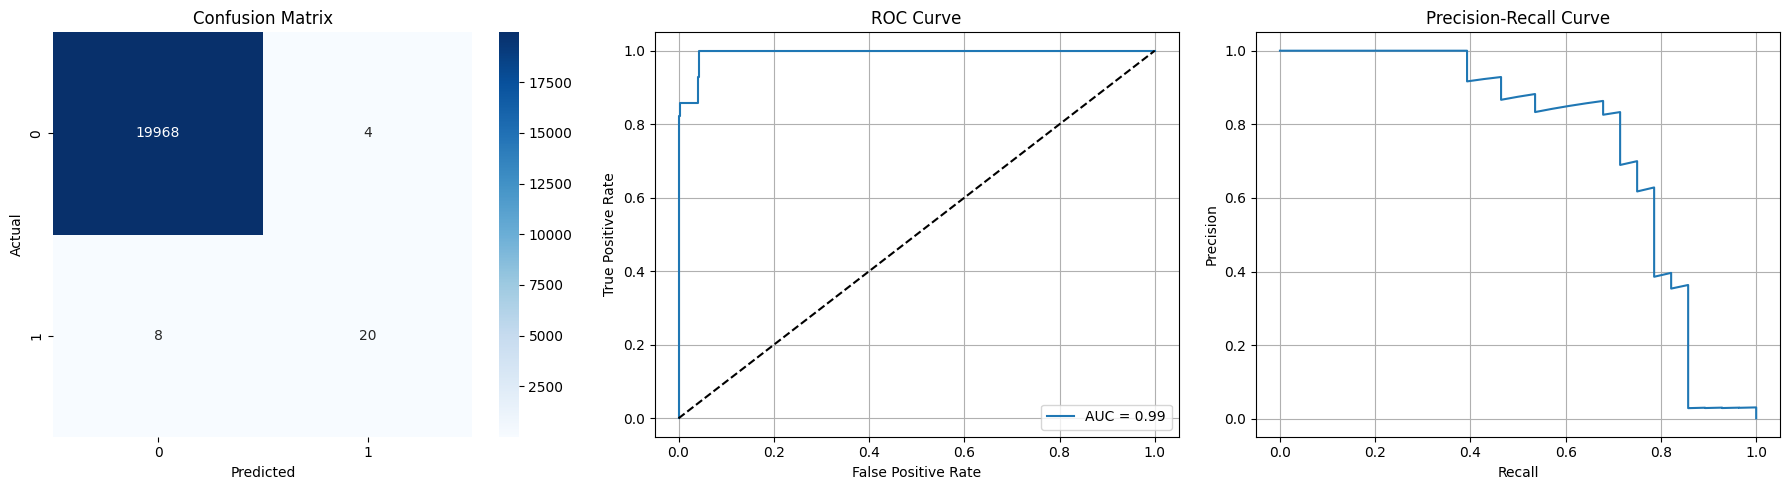

In [8]:
#==================================Part 9==============================================================
# Visualizations

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title("Confusion Matrix")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, final_score)
axes[1].plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, final_score):.2f}")
axes[1].plot([0, 1], [0, 1], 'k--')
axes[1].set_title("ROC Curve")
axes[1].set_xlabel("False Positive Rate")
axes[1].set_ylabel("True Positive Rate")
axes[1].legend()
axes[1].grid(True)

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, final_score)
axes[2].plot(recall, precision)
axes[2].set_title("Precision-Recall Curve")
axes[2].set_xlabel("Recall")
axes[2].set_ylabel("Precision")
axes[2].grid(True)

plt.tight_layout()
plt.show()

X_sample shape: (200, 10)


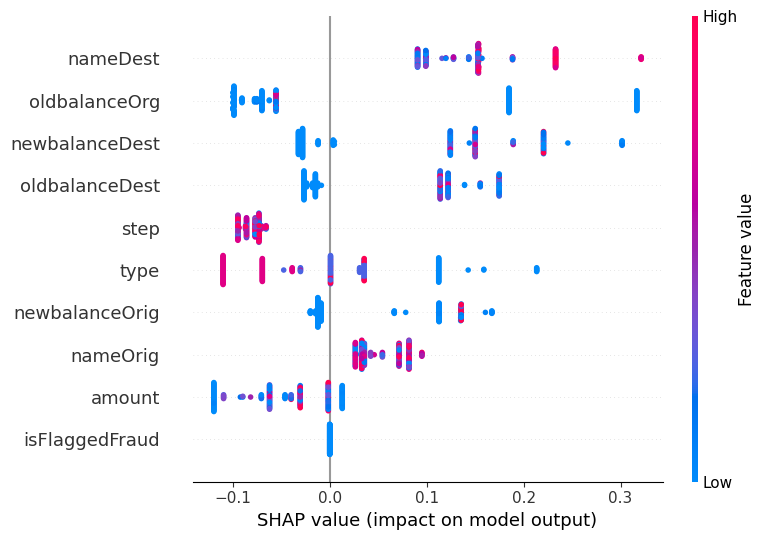

In [9]:
#==================================Part 10==============================================================
# SHAP Analysis

X_sample = pd.DataFrame(X_test, columns=X.columns).sample(n=min(200, len(X_test)), random_state=42)

explainer = shap.TreeExplainer(rf)
shap_vals = explainer.shap_values(X_sample)

print("X_sample shape:", X_sample.shape)
shap_vals_reduced = shap_vals[:, :, 0]
shap.summary_plot(shap_vals_reduced, X_sample)